# Проект 5. Рекомендация тарифов

##### Вводная: <a class="tocSkip">

Вы продолжаете работать в компании сотового оператора «ВодаФон». Отдел аналитики выяснил, что многие клиенты используют невыгодные для компании устаревшие тарифы. Сегодня поступила задача начать переводить пользователей на новые тарифы, первая стадия – проанализировать поведение клиента и на его основе предложить рекомендуемый тариф.

Для построения рекомендательной системы вам предоставлены уже обработанные данные (из `Проекта 3. Определение перспективного тарифа для телеком компании`) о поведении клиентов, которые уже пользуются тарифами «Смарт» и «Ультра».

На данном этапе руководство хочет видеть как можно большее значение *accuracy* (доля правильных ответов), она должна быть по крайней мере 0.75. 

### Цель проекта <a class="tocSkip">
    
    Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Доля правильных ответов должна быть по крайней мере 0.75.

### Описание данных <a class="tocSkip">


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

Обозначение | Признак
:---|:---
сalls | количество звонков,
minutes | суммарная длительность звонков в минутах,
messages | количество sms-сообщений,
mb_used | израсходованный интернет-трафик в Мб,
is_ultra | каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### План по выполнению проекта: <a class="tocSkip">


Шаг 1. [Открытие файла с данными и изучение общей информации](#step1)

Шаг 2. [Разделение исходных данных на обучающую, валидационную и тестовую выборки](#step2)

Шаг 3. [Применение моделей предсказания](#step3)
   - Исследование качества разных моделей в зависимости от их гиперпараметртов. 
   - Промежуточные выводы исследования.
    
Шаг 4. [Проверка качества модели на тестовой выборке](#step4)

Шаг 5. [Проверка моделей на адекватность](#step5)

Шаг 6. [Общий вывод и рекомендации](#step6)

## 0. Установка библиотек <a class="tocSkip">

In [1]:
%pip install seaborn>=0.11 -U

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

Note: you may need to restart the kernel to use updated packages.


In [2]:
#зададим ramdom seed
RS = 2021

## Открытие файла с данными и изучение общей информации <a id='step1'></a>

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data.duplicated().sum()

0

Описательные статистики и разделение классов:

In [6]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
data['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

### Вывод

Для дальнейшего анализа была получена таблица из 5 столбцов и 3214 строк. Названия всех столбцов соответствуют документации, однако написаны с заглавной буквы. Полных дубликатов нет. 

Таким образом у нас есть данные о 3214 клиентах. Для построения модели, предсказывающей тариф (целевой признак) по поведению пользователя есть 4 признака – количество звонков, суммарная длительность звонков в минутах, количество sms-сообщений, израсходованный интернет-трафик в Мб.

## Разделение исходных данных на обучающую, валидационную и тестовую выборки <a id='step2'></a>

Для обучения модели, её валидации и проверки на тестовой выборке нам необходимы три типа выборок: обучающая, валидационная и тестовая. Исходные данные будем разбивать в соотношении 3:1:1.

Перед разделением укажем целевой и остальные признаки: 

In [8]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

In [9]:
#сначала разделим на обучающую и временную части
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=RS)

#поделим временную выборку на валидационную и тестовую
features_validate, features_test, target_validate, target_test = train_test_split(
    features_temp, target_temp, stratify=target_temp, test_size=0.5, random_state=RS)

In [10]:
#проверим разделение
print(features_train.shape)
print(target_train.shape)

print(features_validate.shape)
print(target_validate.shape)

print(features_test.shape)
print(target_test.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


### Вывод

На данном шаге для обучения модели, её валидации и проверки на тестовой выборке мы разбили исходные данные в соотношении 3:1:1.

Размеры получившихся выборок:  
`train`  1928 объектов  
`validate`  643 объектов  
`test 643`  объектов

## Применение моделей предсказания <a id='step3'></a>

Поскольку наш целевой признак качественный, мы решаем задачу классификации. 
Для её решения рассмотрим следующие модели машинного обучения:
1. Дерево решений
2. Случайный лес
3. Логистическая регрессия

### 3.1. Дерево решений

In [11]:
#обучим модель не меняя гиперпараметры
model = DecisionTreeClassifier(random_state=RS)

model.fit(features_train, target_train)

result = model.score(features_validate, target_validate)

print("Accuracy score модели дерева решений на валидационной выборке:", result)

Accuracy score модели дерева решений на валидационной выборке: 0.7169517884914464


In [12]:
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2021, splitter='best')

Теперь будем обучать модель меняя гиперпараметр глубины дерева. Визуализируем полученные результаты.

Accuracy score наилучшей модели на валидационной выборке: 0.8118195956454122 Лучшая глубина: 3


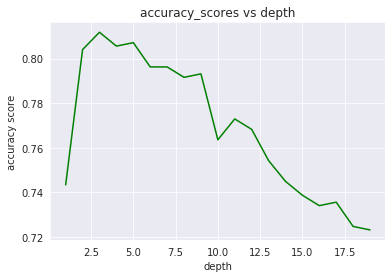

In [13]:
depth_row = []
accuracy_scores = []
best_depth=0
best_result=0
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth = depth, random_state=RS)
    model.fit(features_train, target_train)
    result = model.score(features_validate, target_validate)
    depth_row.append(depth)
    accuracy_scores.append(result)    
    
    if result > best_result:
        best_result = result 
        best_depth = depth
    
    
g = plt.plot(depth_row, 
         accuracy_scores, 
         color="g", 
         )     

plt.xlabel('depth')
plt.ylabel('accuracy score')
plt.title("accuracy_scores vs depth")

print("Accuracy score наилучшей модели на валидационной выборке:", best_result, 
      "Лучшая глубина:", best_depth)

На графике становится видно, что самую большую долю правильных отвветов мы получаем при глубине дерева равной 3. При такой глубине *accuracy* = 0.8118, это хороший результат, поскольу нам необходимо было добиться *accuracy* > 0.75.

### 3.2. Случайный лес

Здесь сразу попробуем найти наилучшую модель. Переберём количество и максимальную глубину деревьев. 

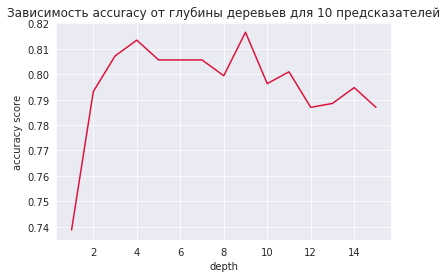

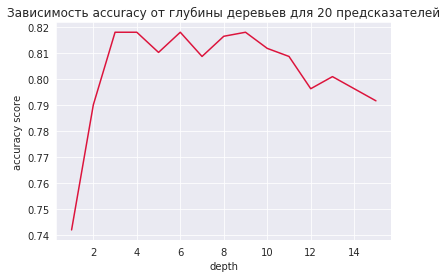

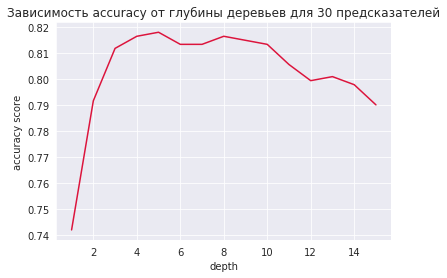

Accuracy score наилучшей модели на валидационной выборке: 0.8180404354587869 Лучшее количество деревьев: 20 Лучшая глубина: 3


In [14]:
#функция для визуализации результатов обучения
def accuracy_plot(depth_row, accuracy_scores, n_est):
    g = plt.plot(depth_row, 
         accuracy_scores,  
         f'#DC143C'        
         )     

    plt.xlabel('depth')
    plt.ylabel('accuracy score')
    plt.title(f"Зависимость аccuracy от глубины деревьев для {n_est} предсказателей")
    plt.show()


best_model = None
best_result = 0
best_depth = 0
best_est = 0
for est in range(10, 31, 10):
    depth_row = []
    accuracy_scores = []
    for depth in range (1, 16):    
        model = RandomForestClassifier(random_state=RS, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train)
        result = model.score(features_validate, target_validate) 
        depth_row.append(depth)
        accuracy_scores.append(result)
        
        if result > best_result:
            best_model = model
            best_result = result 
            best_est = est
            best_depth = depth
            
    accuracy_plot(depth_row, accuracy_scores, est)
    
    
print("Accuracy score наилучшей модели на валидационной выборке:", best_result, 
      "Лучшее количество деревьев:", best_est, 
      "Лучшая глубина:", best_depth)

Самый большой аccuracy score, который мы получили на валидационной выборке: 0.818. Это значение получено при 20 предсказателях и глубине деревьев равной 3. Результат немного лучше чем у предыдущей модели, поэтому пока будем считать эту модель наилучшей для решения нашей задачи.

### 3.3. Логистическая регрессия

In [15]:
model = LogisticRegression(random_state=RS) 
model.fit(features_train, target_train)
result = model.score(features_validate, target_validate) 

print("Accuracy score модели логистической регрессии на валидационной выборке:", result)

Accuracy score модели логистической регрессии на валидационной выборке: 0.6905132192846034


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Как видим, модель логистической регрессии показала долю правильных ответов всего 0.6905 на валидационной выборке. Это меньше чем требуемое значение в 0.75.

### Вывод

На данном этапе мы применяли и исследовали три различные модели:

1. Дерево решений  
Самую большую долю правильных отвветов мы получаем при глубине дерева равной 3. При такой глубине *accuracy* = 0.8118, хороший результат, поскольу нам необходимо было добиться *accuracy* > 0.75.

2. Случайный лес  
Самый большой аccuracy score, который мы получили на валидационной выборке: 0.818. Это значение получено при 20 предсказателях и глубине деревьев равной 3. Результат немного лучше чем у предыдущей модели, поэтому пока будем считать эту модель наилучшей для решения нашей задачи.

3. Логистическая регрессия  
Как видим, модель логистической регрессии показала долю правильных ответов всего 0.6905 на валидационной выборке. Это меньше чем требуемое значение в 0.75.

Таким образом у нас имеются две рабочие модели с хорошей долей ответов. Проверим их на тестовой выборке.

## Проверка качества модели на тестовой выборке <a id='step4'></a>

Первой будем проверять модель Случайный лес с гиперпараметрами 20 предсказателей и глубина деревьев 3:

In [16]:
model = RandomForestClassifier(random_state=RS, n_estimators=20, max_depth=3) 
model.fit(features_train, target_train)
result = model.score(features_test, target_test) 
        
print("Accuracy score наилучшей модели на тестовой выборке:", result, 
      "Количество деревьев:", 20, 
      "Глубина:", 3)        

Accuracy score наилучшей модели на тестовой выборке: 0.8055987558320373 Количество деревьев: 20 Глубина: 3


Accuracy score практически не упал. Впринципе этот результат нас уже устраивает, однако можем посмотреть какой результат покажет модель дерева решений.

In [17]:
model = DecisionTreeClassifier(max_depth = 3, random_state=RS) 
model.fit(features_train, target_train)
result = model.score(features_test, target_test) 
        
print("Accuracy score наилучшей модели на тестовой выборке:", result, 
      "Глубина:", 3)        

Accuracy score наилучшей модели на тестовой выборке: 0.8009331259720062 Глубина: 3


Доля правильных ответов опять немного упала по сравнению с валидационной выборкой, однако все ещё выше чем 0.75.

### Вывод

Доля правильных ответов на тестовой выборке немного падает для всех принятых моделей. Несмотря на это модель **случайного леса** с 20 предсказателями и глубиной 3 показывает наилучшие результаты и рекомендована к использованию для решения нашей бизнес задачи.

## Проверка моделей на адекватность <a id='step5'></a>

Для того, чтобы проверить модели на адекватность нам понадобится предложить такую модель предсказания тарифа, которая будет выдавать предполагаемый тариф в соответствии с кокой-то простой логикой, а также учитывать неравенство классов.

Ещё раз взглянем на данные:

In [18]:
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [19]:
data['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Опишем модель для оценки адекватности:

Для нашей проверочной модели предположим, что все пользователи экономически рациональны: будем считать, что если пользователь много пользуется телефоном (элементами тарифа), то он подключает тариф ультра, если мало – смарт.

Далее оценим "активность" пользователей, упорядочим всех по ней и разделим полученный ряд в соответствии с нашим соотношением классов.

Для оценки активности нормализируем все признаки и сложим их вместе:

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(features)
scaled_features = scaler.transform(features)

#создадим DataFrame обьект
norm_features = pd.DataFrame(data = scaled_features, 
                             columns = features.columns)

norm_features['activity'] = (norm_features['calls'] + 
                             norm_features['minutes'] +
                             norm_features['messages'] +
                             norm_features['mb_used']
                            )

norm_features.head()

,calls,minutes,messages,mb_used,activity
0,0.163934,0.191108,0.370536,0.400344,1.125923
1,0.348361,0.316624,0.250000,0.456259,1.371245
2,0.315574,0.286546,0.383929,0.423362,1.409410
3,0.434426,0.456803,0.361607,0.169610,1.422447
4,0.270492,0.256571,0.004464,0.291538,0.823065


In [21]:
#отсортируем по активности:
sorted_norm_features = norm_features.sort_values(by='activity').reset_index(drop=False)   
sorted_norm_features.head()

,index,calls,minutes,messages,mb_used,activity
0,3107,0.000000,0.000000,0.0,0.010670,0.010670
1,2137,0.004098,0.000839,0.0,0.013464,0.018402
2,540,0.008197,0.001219,0.0,0.012396,0.021812
3,967,0.008197,0.005521,0.0,0.009628,0.023346
4,1065,0.008197,0.001225,0.0,0.019288,0.028710


Мы получили наш показатель активности пользователя. Теперь пользователям с низкой акитвностью припишем значение 0 и наоборот.

In [22]:
sorted_norm_features.loc[0 : 2229, 'predicted_tariff'] = 0 
sorted_norm_features.loc[2230 : 3214, 'predicted_tariff'] = 1 

#вернем старые индексы
final_norm_features = sorted_norm_features.sort_values(by='index').reset_index(drop=True).drop(['index'], axis=1)
final_norm_features.head()

,calls,minutes,messages,mb_used,activity,predicted_tariff
0,0.163934,0.191108,0.370536,0.400344,1.125923,0.0
1,0.348361,0.316624,0.250000,0.456259,1.371245,1.0
2,0.315574,0.286546,0.383929,0.423362,1.409410,1.0
3,0.434426,0.456803,0.361607,0.169610,1.422447,1.0
4,0.270492,0.256571,0.004464,0.291538,0.823065,0.0


Наша модель готова, посчитаем с какой точностью она угадывает тариф:

In [23]:
accuracy = accuracy_score(final_norm_features['predicted_tariff'], target) 
accuracy

0.6916614810205352

Доля правильных ответов нашей модели, не использующей машинное обучение, составила 0.69. Как видим, наши модели случайного леса и дерева решений построены не зря – они имеют большую точность (около 0.8). 

### Вывод

На данном этапе мы проверяли полученные модели на адекватность.

Поскольку классы были не равны между собой мы предложили следующую модель для сравнения:

В начале мы редположили, что все пользователи экономически рациональны: если пользователь много пользуется телефоном (элементами тарифа), то он подключает тариф ультра, если мало – смарт. Далее оценили "активность" пользователей (получили сумму нормализованных признаков), упорядочили всех по ней и разделили полученный ряд в соответствии с нашим соотношением классов.

Доля правильных ответов нашей модели, не использующей машинное обучение составила 0.69. Наши построенные модели машинного обучения имеют большую точность (около 0.8 правильных ответов).

## Общий вывод<a id='step6'></a>

**6.1.** Мы обработали и проанализировали информацию о 3214 клиентах. Для построения модели, предсказывающей тариф (целевой признак) по поведению пользователя использовалось 4 признака – количество звонков, суммарная длительность звонков в минутах, количество sms-сообщений, израсходованный интернет-трафик в Мб.

Для обучения модели, её валидации и проверки на тестовой выборке мы разбили исходные данные в соотношении 3:1:1.

Размеры получившихся выборок:  
`train` 1928 объектов  
`validate` 643 объектов  
`test` 643 объектов  

**6.2.** Далее мы применяли и исследовали три различные модели:

1. Дерево решений  
Самую большую долю правильных отвветов мы получили при глубине дерева равной 3. При такой глубине *accuracy* = 0.8118, хороший результат, поскольу нам необходимо было добиться *accuracy* > 0.75.

2. Случайный лес  
Самый большой аccuracy score, который мы получили на валидационной выборке: 0.818. Это значение получено при 20 предсказателях и глубине деревьев равной 3. Результат немного лучше чем у предыдущей модели, поэтому на данном этапе считаем эту модель наилучшей для решения нашей задачи.

3. Логистическая регрессия  
Как видим, модель логистической регрессии показала долю правильных ответов всего 0.6905 на валидационной выборке. Это меньше чем требуемое значение в 0.75.

Модель | Наилучший *аccuracy score*
:---|:---
Дерево решений | 0.81
Случайный лес | 0.82
Логистическая регрессия | 0.69

Таким образом мы получили две рабочие модели (Дерево решений и Случайный лес) с хорошей долей ответов. Модель случайного леса с 20 предсказателями и глубиной 3 показывает наилучшие результаты и рекомендована к использованию для решения нашей бизнес задачи.

**6.3.** Далее шла проверка моеделей на тестовой выборке. Как оказалось, доля правильных ответов на тестовой выборке немного падает для всех принятых моделей. Несмотря на это модель **случайного леса** с 10 предсказателями и глубиной 7 показывает наилучшие результаты и рекомендована к использованию для решения нашей бизнес задачи.

**6.4.** На данном этапе мы проверяли полученные модели на адекватность.

Поскольку классы были не равны между собой мы предложили следующую модель для сравнения:

В начале мы редположили, что все пользователи экономически рациональны: если пользователь много пользуется телефоном (элементами тарифа), то он подключает тариф ультра, если мало – смарт. Далее оценили "активность" пользователей (получили сумму нормализованных признаков), упорядочили всех по ней и разделили полученный ряд в соответствии с нашим соотношением классов.

Доля правильных ответов нашей модели, не использующей машинное обучение составила 0.69. Наши построенные модели машинного обучения имеют большую точность (около 0.8 правильных ответов).